In [1]:
!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
### the meaning of prediction about stock market
from numpy.core.numeric import ones_like
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


[*********************100%***********************]  1 of 1 completed


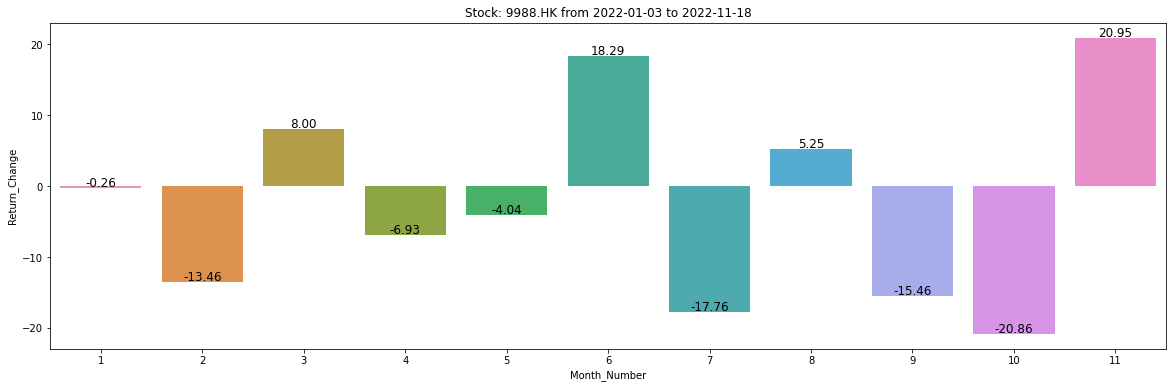

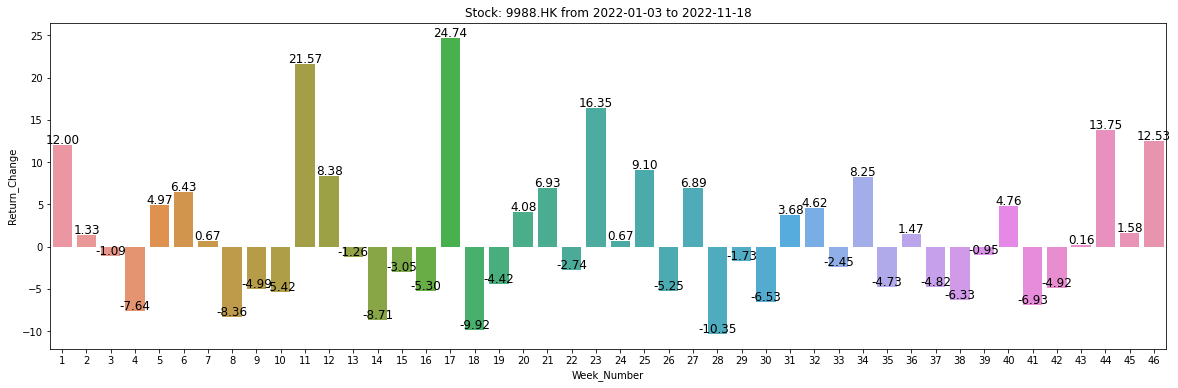

In [2]:
# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
  df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
  #df_data.head()
  return df_data

# calculate the daily return by (current_index - previous_index) / previous_index
def calculate_daily_return(df_data, OHLC_index="Close"):
  name1 = OHLC_index+"_previous"
  df_data[name1] = df_data[OHLC_index].shift(1)
  name2 = OHLC_index+"_delta"
  df_data[name2] = df_data[OHLC_index] - df_data[name1]
  name3 = OHLC_index+"_return"
  df_data[name3] = df_data[name2] / df_data[name1]
  del df_data[name1]
  del df_data[name2]
  new_feature = name3
  return df_data #, new_feature

# get the market movement (yesterday -> today) based on daily return, 
  # 1 means rise and 0 fall
def get_market_movement(df_data, signal_name="Close_return"):
  df_data["movement"] = df_data[signal_name]>0
  df_data["movement"] = df_data["movement"].astype(int)
  return df_data

# convert the time to be string type: yyyy-mm-dd
  # get month number & week number
def get_ymt_date(df_data):
  df_data["ymd_time"] = df_data.index
  df_data["ymd_time"] = df_data["ymd_time"].astype(str)
  df_data["ymd_time"] = df_data["ymd_time"].str.slice(0,10)
  # month
  df_data["monthNumber"] = df_data["ymd_time"].str.slice(5,7)
  df_data["monthNumber"] = df_data["monthNumber"].astype(int)
  # week
  df_data['ymd_time'] = pd.to_datetime(df_data['ymd_time'], errors ='coerce')
  df_data['weekNumber'] = df_data['ymd_time'].dt.isocalendar().week
  return df_data

# calculate the monthly return
def month_change(df_data, feature="Close"):
    x, y = [], []
    months = set( list(df_data['monthNumber']) )
    for m in list(months)[:]:
        tmp_df = df_data[ df_data['monthNumber']==m ]
        tmp_list = tmp_df[feature]
        m_start, m_end = tmp_list[0], tmp_list[-1]
        change = (m_end - m_start)/m_start * 100
        x.append(m)
        y.append(change)
        #print(m_start, m_end)
    return x, y

# calculate the weekly return
def week_change(df_data, feature="Close"):
    x, y = [], []
    weeks = set( list(df_data['weekNumber']) )
    for w in list(weeks)[:]:
        tmp_df = df_data[ df_data['weekNumber']==w ]
        tmp_list = tmp_df[feature]
        w_start, w_end = tmp_list[0], tmp_list[-1]
        change = (w_end - w_start)/w_start * 100
        x.append(w)
        y.append(change)
    return x, y

# draw bar chart
def draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name="", xt=None):
    data = {
            x_name: x_axis,
            y_name: y_axis
           }
    df = pd.DataFrame(data, columns=[x_name, y_name])
    # Defining the plot size
    # Defining the values for x-axis, y-axis
    # and from which dataframe the values are to be picked
    fig, ax = plt.subplots(figsize=(20, 6))
    plots = sns.barplot(x=x_name, y=y_name, data=df)
    if xt is not None:
        ax.set_xticks(x_axis)
        ax.set_xticklabels(xt)

    # Iterrating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=12, xytext=(0, 5),
                       textcoords='offset points')
    # Setting the title for the graph
    plt.title("Stock: " + tn + " " + title_name)
    # Finally showing the plot
    plt.show()
    return 

###
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團 # AAPL
hk_tickers = ["3690.HK", "9618.HK", "1024.HK", "9866.HK"]
tn = "9988.HK" 
st, et = "2022-01-01", "2022-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data)
df_data = get_market_movement(df_data)
df_data = get_ymt_date(df_data)

date_list = list(df_data.index)
start_date, end_date = date_list[0], date_list[-1]
start_date, end_date = str(start_date)[:10], str(end_date)[:10]
title_name = "from " + start_date + " to " + end_date
# graph: monthly return 
x_axis, y_axis = month_change(df_data, "Close")
x_name, y_name = "Month_Number", "Return_Change"
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name)
# graph: weekly return 
x_axis, y_axis = week_change(df_data, "Close")
x_name, y_name = "Week_Number", "Return_Change"
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name)

In [74]:
# every week has its return: 
  # close price of the first business day of this week 
    # vs 
  # close price of the last business day of this week
def get_weekly_return(df_data, start_week=1, end_week=20):
  x, y = week_change(df_data, "Close")
  dic = {}
  for i in range(len(x)):
    week_num = x[i]
    if week_num<start_week or week_num>=end_week:
      continue
    dic[x[i]] = y[i]
  return dic

### permutation calculator
# it does not consider the order, so it is Cn
def permutation_Cn(n, m):
  print(n, m)
  # n! / ( m! * (n-m)! )
    # v1 = (m+1)*(m+2)*...*n 
    # v2 = 1*2*..*(n-m)
    # v3 = v1/v2
  v1 = 1
  i = m+1
  while i<=n:
    v1 = v1 * i
    i += 1
  v2 = 1
  i = 1
  while i<=(n-m):
    v2 = v2 * i
    i += 1
  return v1, v2, round(v1/v2)


# how much n% correct prediction is robust enough to earn money 
# suppose that: n% prediction is correct, 1-n% prediction is incorrect
# while the order is random, to analyze the robustness
# for example, 4-day stocks, 0 means wrong prediction, 1 means right prediction
  # [0, 1, 0, 1], [1, 1, 0, 0] are 2 types of prediction / 2 permutations
    # with the same percentatge correct prediction: 50%, 
    # while they may have different returns
# this function is to generate huge amount of permutations to simulate big-data analysis
  # to figure out the how much percentage to earn money 
  # for certain percentage correct prediction
def generate_permutation(random_seed, list_len, accuracy_ratio):
  ones = int(accuracy_ratio * list_len)
  zeros = list_len - ones
  a_list = []
  for i in range(ones):
    a_list.append(1)
  for i in range(zeros):
    a_list.append(0)
  random.seed(random_seed)
  random.shuffle(a_list)
  return a_list

# get possible permutations under a certain times of random generation
def get_possible_permutations(list_len, accuracy_ratio, num):
  notch_point = []
  for i in range(100):
    notch_point.append( round((i+1)/100*num) )
  permutation_set = set()
  for i in range(num):
    tmp_list = generate_permutation(i, list_len, accuracy_ratio)
    permutation_set.add( tuple(tmp_list) )
    if i in notch_point:
      print("=", end="")
  permutation_list = []
  for it in permutation_set:
    permutation_list.append( list(it) )
  print()
  return permutation_list

# strategy 1
def basic_level_strategy(week_num_return, transact_fee=-0.25*0.01):
  base_profit = 1.0
  weeks = sorted(list( week_num_return.keys() ))
  for w in weeks:
    base_profit = base_profit * (1+transact_fee) # enter market
    weekly_return = week_num_return[w]/100
    #print(w, weekly_return)
    base_profit = base_profit * (1+weekly_return) # get profit
    base_profit = base_profit * (1+transact_fee) # enter market
  return base_profit

# strategy 2
  # according to prediction about the market, 
    # when prediction is rise, then enter matket, or hold if already in the market
    # when prediction is fall, then exit market if already in the market, or do nothing
def algo_trading_strategy(week_predictions, week_num_return, transact_fee=-0.25*0.01):
  base_profit = 1.0
  weeks = sorted(list( week_num_return.keys() ))
  in_market_or_not = 0 # 0 -> not in the market, 1 -> in the market
  for w in weeks:
    weekly_return = week_num_return[w]/100
    pred = week_predictions[w]
    # if pred==0, it means prediction is wrong: prediction rise but market fall, prediction fall but market rise
    # if pred==1, it means prediction is right: prediction rise and market rise, prediction fall and market fall
    if pred==0:
      if weekly_return>0: # prediction fall but market rise
        if in_market_or_not==1: # if in the market, then exit market
          base_profit = base_profit * (1+transact_fee) 
          in_market_or_not = 0
        #else: # if not in the market, then do nothing
      else: # prediction rise but market fall
        if in_market_or_not==1: # if in the market, then hold
          base_profit = base_profit * (1+weekly_return) # get loss
        else: # if not in the market, then enter market & get loss
          base_profit = base_profit * (1+transact_fee) 
          base_profit = base_profit * (1+weekly_return) 
          in_market_or_not = 1
    if pred==1:
      if weekly_return>0: # prediction rise and market rise
        if in_market_or_not==1: # if in the market, then hold
          base_profit = base_profit * (1+weekly_return) # get gain
        else: # if not in the market, then enter market & get gain
          base_profit = base_profit * (1+transact_fee) 
          base_profit = base_profit * (1+weekly_return)
          in_market_or_not = 1
      else: # prediction fall and market fall
        if in_market_or_not==1: # if in the market, then exit market
          base_profit = base_profit * (1+transact_fee)
          in_market_or_not = 0
        #else: # if not in the market, then do nothing
  # finally
  if in_market_or_not==1:
    base_profit = base_profit * (1+transact_fee) # exit market
    in_market_or_not = 0
  return base_profit

# 
def forge_week_predictions(simulation, week_num_return):
  week_predictions = {}
  weeks = sorted(list( week_num_return.keys() ))
  i = 0
  while i<len(simulation):
    week_predictions[weeks[i]] = simulation[i]
    i += 1
  return week_predictions

# calculate common statistical indicators for list-type data, 
  # such as: max, min, avg/mean, median, 10-percentile, 90-percentile
def statistical_indicators(tmp_list):
  tmp_list = sorted(tmp_list)
  L = len(tmp_list)
  mx, mn = max(tmp_list), min(tmp_list)
  avg = sum(tmp_list)/len(tmp_list)
  med = tmp_list[L//2]
  last_10 = tmp_list[ int(L*0.1) ]
  first_10 = tmp_list[ int(L*0.9) ]
  return round(mx, 3), round(mn, 3), round(avg, 3), round(med, 3), round(first_10, 3), round(last_10, 3)

# draw lines, those lines share the same x values, but different y values
def draw_lines(x, ys, tn, title_name=""):
    predict_accuracy_list = x
    [
      win_ratio_list, basic_level_list,
      max_predict_list, min_predict_list, avg_predict_list,
      med_predict_list, f10_predict_list, l10_predict_list
      ] = ys
    #
    fig = plt.subplots(figsize =(12, 6))
    plt.plot(predict_accuracy_list, win_ratio_list, label ='win_ratio_list') # , color ='r'
    plt.plot(predict_accuracy_list, basic_level_list, label ='basic_level_list')
    plt.plot(predict_accuracy_list, max_predict_list, label ='max_predict_list')
    plt.plot(predict_accuracy_list, min_predict_list, label ='min_predict_list')
    plt.plot(predict_accuracy_list, avg_predict_list, label ='avg_predict_list')
    plt.plot(predict_accuracy_list, med_predict_list, label ='med_predict_list')
    plt.plot(predict_accuracy_list, f10_predict_list, label ='f10_predict_list')
    plt.plot(predict_accuracy_list, l10_predict_list, label ='l10_predict_list')
    plt.plot(predict_accuracy_list, [1]*len(win_ratio_list), label ='100% groud-level')
    #
    plt.title("the meaning of stock prediction: " + tn + " " + title_name)
    plt.xlabel('prediction accuracy')
    plt.ylabel("related analysis")
    #
    plt.legend()
    plt.show()
    return

In [78]:
  #
start_week, end_week = 21, 41



Timestamp('2022-05-23 00:00:00')

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
80040 175606 0.456 % win
1.059  vs  0.708 0.889 1.062 1.054 1.249 1.541
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
106839 159518 0.67 % win
1.059  vs  0.753 0.954 1.139 1.131 1.336 1.629
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
100213 119689 0.837 % win
1.059  vs  0.805 1.026 1.221 1.213 1.426 1.712
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
69118 73700 0.938 % win
1.059  vs  0.868 1.107 1.31 1.303 1.519 1.8
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36308 36854 0.985 % win
1.059  vs  0.94 1.196 1.404 1.402 1.615 1.89
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14713 14727 0.999 % win
1.059  vs  1.026 1.294 1.506 1.511 1.712 1.959


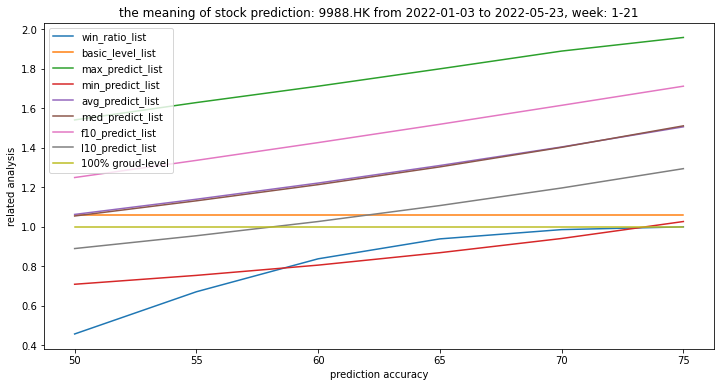

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
92589 175606 0.527 % win
1.011  vs  0.708 0.869 1.038 1.03 1.22 1.471
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
116295 159518 0.729 % win
1.011  vs  0.753 0.93 1.11 1.101 1.301 1.556
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
104046 119689 0.869 % win
1.011  vs  0.805 0.998 1.188 1.179 1.384 1.636
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
70095 73700 0.951 % win
1.011  vs  0.861 1.076 1.27 1.263 1.47 1.719
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36489 36854 0.99 % win
1.011  vs  0.929 1.162 1.359 1.357 1.557 1.804
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14724 14727 1.0 % win
1.011  vs  1.005 1.255 1.453 1.462 1.647 1.878


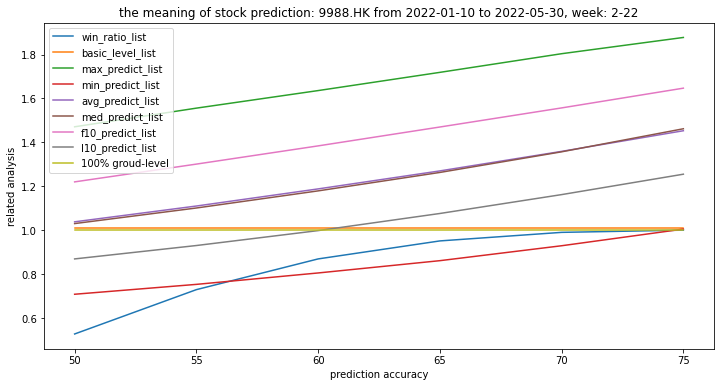

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
104385 175606 0.594 % win
0.971  vs  0.703 0.853 1.016 1.009 1.193 1.431
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
124871 159518 0.783 % win
0.971  vs  0.747 0.914 1.089 1.08 1.273 1.513
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
108062 119689 0.903 % win
0.971  vs  0.798 0.983 1.166 1.157 1.356 1.59
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
71555 73700 0.971 % win
0.971  vs  0.861 1.06 1.249 1.242 1.44 1.672
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36743 36854 0.997 % win
0.971  vs  0.921 1.148 1.338 1.337 1.528 1.755
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14727 14727 1.0 % win
0.971  vs  0.997 1.241 1.432 1.443 1.618 1.826


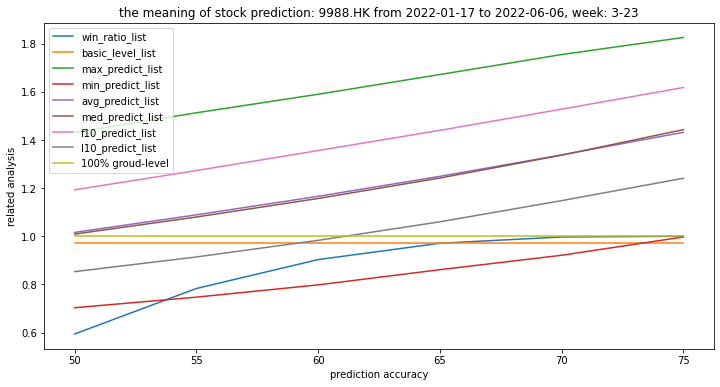

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
61411 175606 0.35 % win
1.142  vs  0.747 0.927 1.103 1.094 1.292 1.607
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
92093 159518 0.577 % win
1.142  vs  0.798 1.0 1.189 1.182 1.392 1.692
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
93927 119689 0.785 % win
1.142  vs  0.854 1.082 1.283 1.276 1.497 1.789
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
67923 73700 0.922 % win
1.142  vs  0.921 1.171 1.383 1.377 1.604 1.881
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36186 36854 0.982 % win
1.142  vs  0.997 1.269 1.491 1.487 1.715 1.976
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14703 14727 0.998 % win
1.142  vs  1.088 1.38 1.607 1.607 1.828 2.074


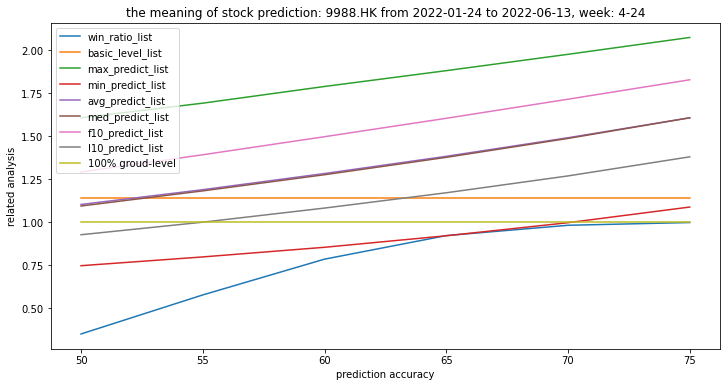

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
43257 175606 0.246 % win
1.244  vs  0.762 0.961 1.152 1.142 1.358 1.692
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
70470 159518 0.442 % win
1.244  vs  0.81 1.034 1.238 1.23 1.457 1.779
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
78024 119689 0.652 % win
1.244  vs  0.866 1.113 1.329 1.323 1.561 1.881
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
60942 73700 0.827 % win
1.244  vs  0.926 1.2 1.428 1.422 1.667 1.976
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
34583 36854 0.938 % win
1.244  vs  0.999 1.296 1.534 1.529 1.776 2.074
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14531 14727 0.987 % win
1.244  vs  1.09 1.404 1.647 1.646 1.885 2.159


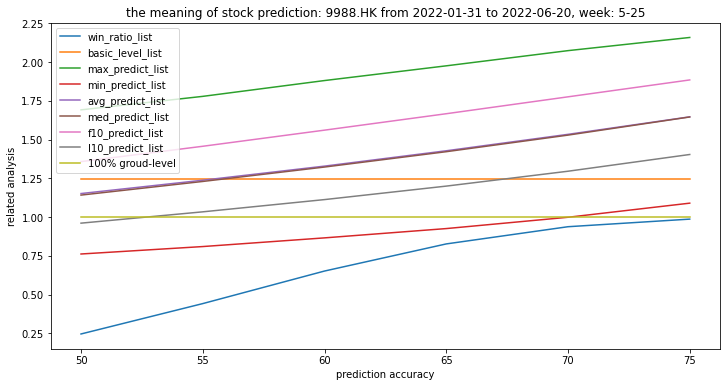

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
35431 175606 0.202 % win
1.293  vs  0.775 0.981 1.174 1.164 1.382 1.745
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
62322 159518 0.391 % win
1.293  vs  0.825 1.057 1.264 1.256 1.486 1.837
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
73107 119689 0.611 % win
1.293  vs  0.882 1.14 1.36 1.353 1.595 1.942
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
59156 73700 0.803 % win
1.293  vs  0.952 1.232 1.464 1.458 1.707 2.042
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
34228 36854 0.929 % win
1.293  vs  1.038 1.333 1.576 1.571 1.822 2.145
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14508 14727 0.985 % win
1.293  vs  1.133 1.449 1.695 1.695 1.939 2.233


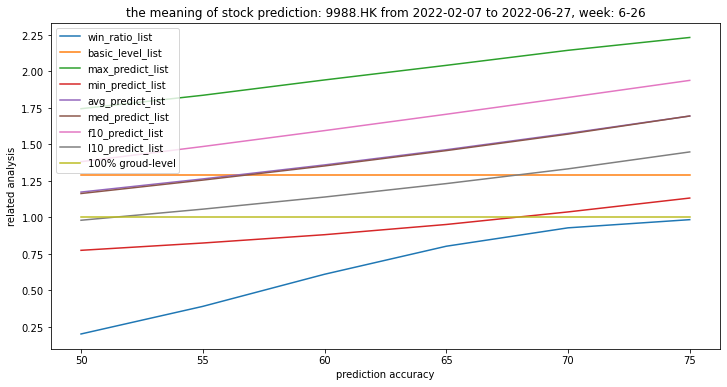

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
60495 175606 0.344 % win
1.151  vs  0.73 0.925 1.108 1.099 1.305 1.648
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
88953 159518 0.558 % win
1.151  vs  0.775 0.997 1.193 1.185 1.403 1.737
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
90635 119689 0.757 % win
1.151  vs  0.829 1.075 1.283 1.276 1.505 1.834
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
66276 73700 0.899 % win
1.151  vs  0.894 1.161 1.381 1.375 1.611 1.928
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
35860 36854 0.973 % win
1.151  vs  0.975 1.256 1.485 1.481 1.718 2.026
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14663 14727 0.996 % win
1.151  vs  1.064 1.365 1.598 1.597 1.829 2.108


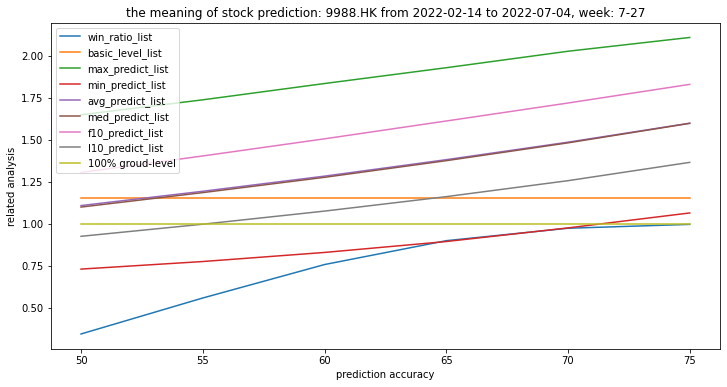

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
45457 175606 0.259 % win
1.222  vs  0.77 0.959 1.141 1.132 1.337 1.669
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
76583 159518 0.48 % win
1.222  vs  0.819 1.036 1.232 1.224 1.441 1.756
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
84623 119689 0.707 % win
1.222  vs  0.876 1.121 1.329 1.324 1.551 1.857
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
64721 73700 0.878 % win
1.222  vs  0.956 1.215 1.435 1.43 1.665 1.953
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
35656 36854 0.967 % win
1.222  vs  1.03 1.318 1.548 1.544 1.782 2.052
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14658 14727 0.995 % win
1.222  vs  1.13 1.434 1.67 1.669 1.9 2.155


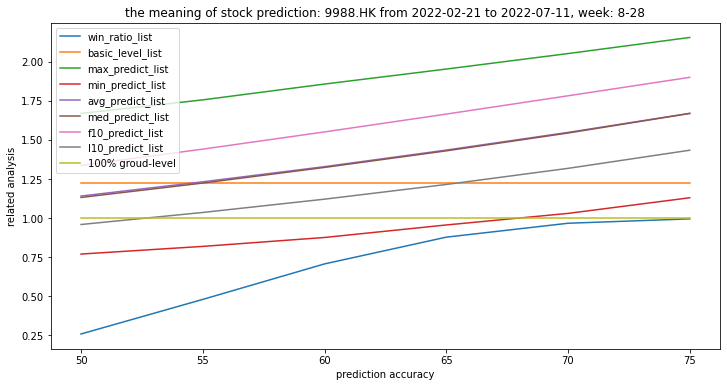

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
50591 175606 0.288 % win
1.196  vs  0.753 0.948 1.129 1.12 1.323 1.669
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
82418 159518 0.517 % win
1.196  vs  0.805 1.025 1.22 1.213 1.429 1.756
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
88594 119689 0.74 % win
1.196  vs  0.861 1.111 1.319 1.312 1.539 1.857
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
66262 73700 0.899 % win
1.196  vs  0.929 1.205 1.425 1.42 1.654 1.953
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
35953 36854 0.976 % win
1.196  vs  1.013 1.309 1.539 1.535 1.774 2.052
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14684 14727 0.997 % win
1.196  vs  1.115 1.427 1.663 1.662 1.896 2.155


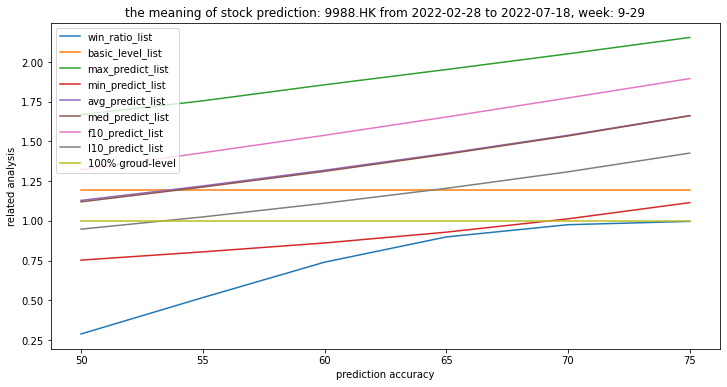

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
44065 175606 0.251 % win
1.237  vs  0.753 0.961 1.149 1.139 1.35 1.717
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
73749 159518 0.462 % win
1.237  vs  0.805 1.038 1.239 1.231 1.455 1.816
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
82015 119689 0.685 % win
1.237  vs  0.861 1.122 1.337 1.33 1.565 1.909
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
63416 73700 0.86 % win
1.237  vs  0.939 1.215 1.442 1.436 1.679 2.006
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
35310 36854 0.958 % win
1.237  vs  1.013 1.318 1.555 1.552 1.797 2.107
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14625 14727 0.993 % win
1.237  vs  1.115 1.434 1.676 1.676 1.917 2.193


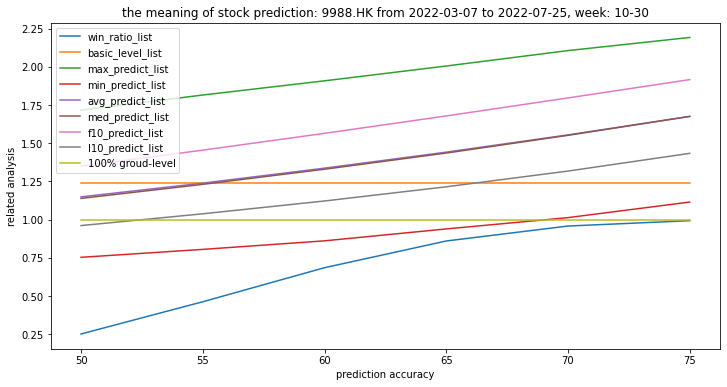

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
46344 175606 0.264 % win
1.222  vs  0.749 0.956 1.142 1.132 1.341 1.699
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
76541 159518 0.48 % win
1.222  vs  0.801 1.033 1.232 1.224 1.445 1.793
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
84147 119689 0.703 % win
1.222  vs  0.861 1.117 1.33 1.323 1.555 1.909
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
64363 73700 0.873 % win
1.222  vs  0.929 1.21 1.435 1.43 1.67 2.006
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
35541 36854 0.964 % win
1.222  vs  1.013 1.314 1.548 1.545 1.788 2.107
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14651 14727 0.995 % win
1.222  vs  1.115 1.431 1.67 1.669 1.909 2.193


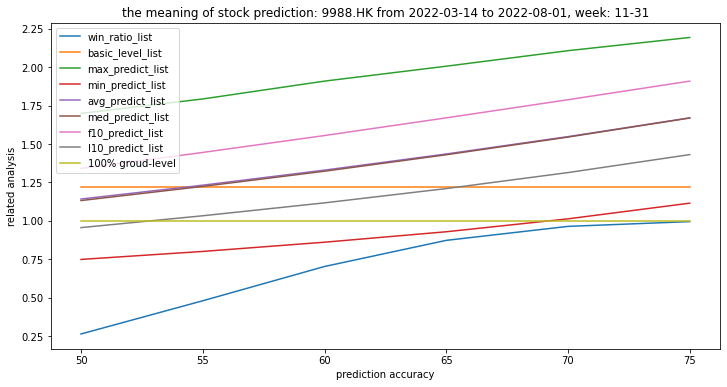

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
84330 175606 0.48 % win
1.043  vs  0.727 0.898 1.053 1.046 1.217 1.494
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
110769 159518 0.694 % win
1.043  vs  0.777 0.961 1.127 1.122 1.299 1.57
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
103299 119689 0.863 % win
1.043  vs  0.83 1.03 1.206 1.204 1.385 1.65
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
70717 73700 0.96 % win
1.043  vs  0.888 1.106 1.291 1.291 1.473 1.733
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36650 36854 0.994 % win
1.043  vs  0.958 1.191 1.381 1.386 1.564 1.804
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14726 14727 1.0 % win
1.043  vs  1.045 1.283 1.478 1.487 1.658 1.869


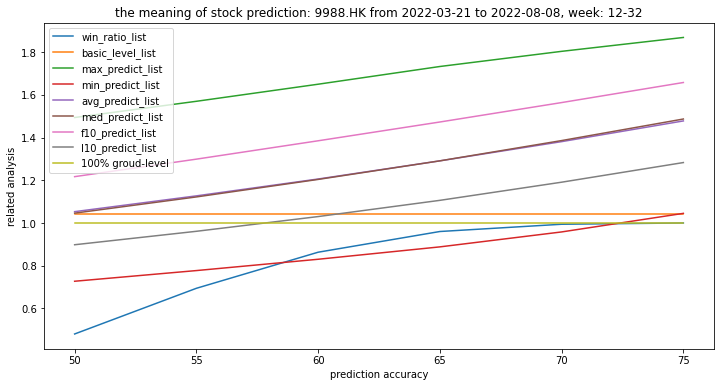

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
93883 175606 0.535 % win
1.006  vs  0.716 0.882 1.034 1.027 1.196 1.449
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
117506 159518 0.737 % win
1.006  vs  0.76 0.943 1.105 1.101 1.275 1.523
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
106291 119689 0.888 % win
1.006  vs  0.812 1.009 1.181 1.179 1.356 1.599
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
71469 73700 0.97 % win
1.006  vs  0.869 1.082 1.263 1.263 1.44 1.664
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36721 36854 0.996 % win
1.006  vs  0.929 1.162 1.35 1.354 1.527 1.732
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14726 14727 1.0 % win
1.006  vs  1.014 1.252 1.442 1.452 1.618 1.796


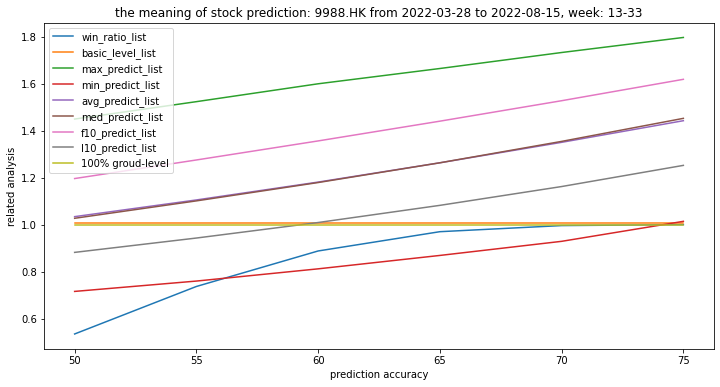

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
97237 175606 0.554 % win
0.994  vs  0.716 0.878 1.028 1.022 1.187 1.432
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
120722 159518 0.757 % win
0.994  vs  0.76 0.939 1.099 1.095 1.266 1.504
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
108096 119689 0.903 % win
0.994  vs  0.812 1.006 1.176 1.174 1.348 1.58
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
71958 73700 0.976 % win
0.994  vs  0.869 1.08 1.258 1.259 1.433 1.653
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36777 36854 0.998 % win
0.994  vs  0.929 1.161 1.345 1.351 1.52 1.72
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14727 14727 1.0 % win
0.994  vs  1.014 1.25 1.439 1.449 1.611 1.783


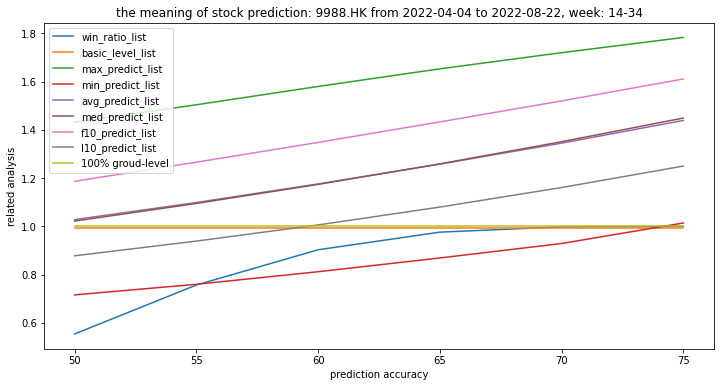

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
52171 175606 0.297 % win
1.179  vs  0.788 0.957 1.119 1.112 1.292 1.55
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
81058 159518 0.508 % win
1.179  vs  0.837 1.023 1.196 1.192 1.377 1.628
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
85864 119689 0.717 % win
1.179  vs  0.894 1.094 1.279 1.277 1.465 1.71
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
64692 73700 0.878 % win
1.179  vs  0.957 1.173 1.366 1.368 1.555 1.789
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
35574 36854 0.965 % win
1.179  vs  1.023 1.259 1.46 1.466 1.648 1.862
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14670 14727 0.996 % win
1.179  vs  1.102 1.355 1.559 1.571 1.743 1.93


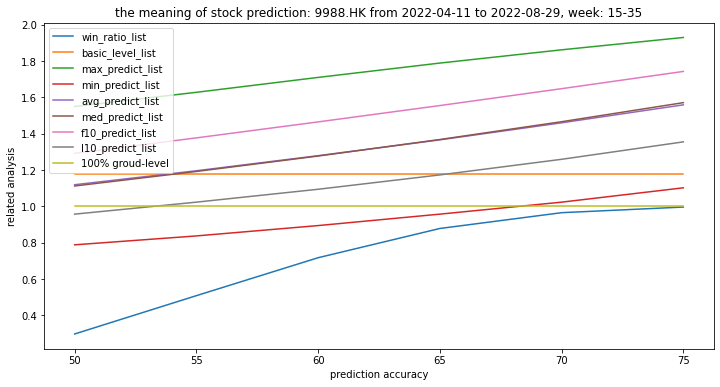

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
56400 175606 0.321 % win
1.158  vs  0.789 0.95 1.11 1.103 1.279 1.529
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
86060 159518 0.54 % win
1.158  vs  0.837 1.016 1.187 1.183 1.365 1.608
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
89539 119689 0.748 % win
1.158  vs  0.894 1.088 1.27 1.268 1.453 1.689
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
66253 73700 0.899 % win
1.158  vs  0.956 1.168 1.359 1.36 1.544 1.767
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
35959 36854 0.976 % win
1.158  vs  1.023 1.255 1.452 1.459 1.639 1.854
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14701 14727 0.998 % win
1.158  vs  1.102 1.351 1.553 1.566 1.734 1.93


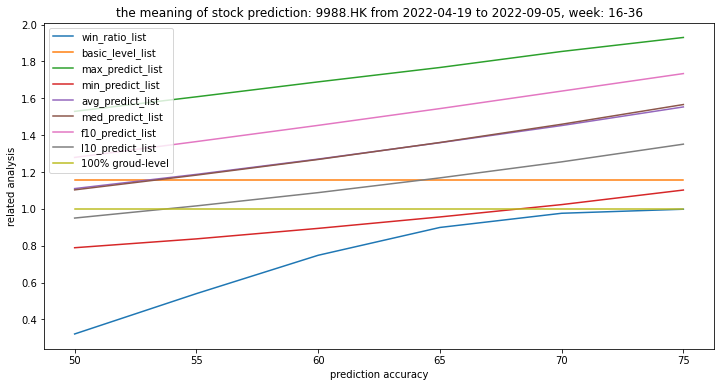

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
40280 175606 0.229 % win
1.241  vs  0.805 0.981 1.149 1.142 1.328 1.608
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
67493 159518 0.423 % win
1.241  vs  0.845 1.046 1.226 1.221 1.414 1.688
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
75971 119689 0.635 % win
1.241  vs  0.903 1.117 1.309 1.306 1.502 1.772
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
60110 73700 0.816 % win
1.241  vs  0.966 1.196 1.396 1.397 1.593 1.854
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
34363 36854 0.932 % win
1.241  vs  1.033 1.282 1.489 1.495 1.686 1.93
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14519 14727 0.986 % win
1.241  vs  1.113 1.377 1.588 1.599 1.782 2.001


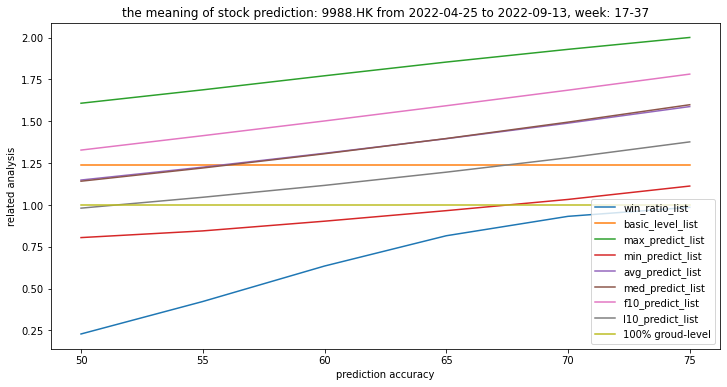

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
120271 175606 0.685 % win
0.947  vs  0.758 0.896 1.0 0.997 1.108 1.296
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
140519 159518 0.881 % win
0.947  vs  0.796 0.949 1.059 1.057 1.172 1.361
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
116507 119689 0.973 % win
0.947  vs  0.845 1.006 1.121 1.12 1.238 1.428
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
73523 73700 0.998 % win
0.947  vs  0.903 1.067 1.187 1.187 1.307 1.494
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36854 36854 1.0 % win
0.947  vs  0.966 1.133 1.256 1.257 1.378 1.555
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14727 14727 1.0 % win
0.947  vs  1.033 1.205 1.329 1.331 1.449 1.612


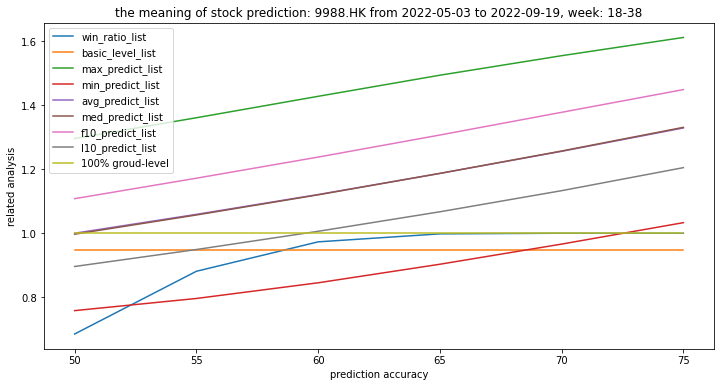

prediction accuracy 50.0 %
20 10
184756 175606 95.05 %
106107 175606 0.604 % win
0.985  vs  0.789 0.919 1.02 1.017 1.125 1.296
prediction accuracy 55.0 %
20 11
167960 159518 94.97 %
132578 159518 0.831 % win
0.985  vs  0.828 0.97 1.078 1.076 1.187 1.361
prediction accuracy 60.0 %
20 12
125970 119689 95.01 %
114496 119689 0.957 % win
0.985  vs  0.878 1.026 1.139 1.138 1.251 1.428
prediction accuracy 65.0 %
20 13
77520 73700 95.07 %
73390 73700 0.996 % win
0.985  vs  0.939 1.086 1.203 1.204 1.318 1.494
prediction accuracy 70.0 %
20 14
38760 36854 95.08 %
36854 36854 1.0 % win
0.985  vs  1.004 1.151 1.271 1.273 1.385 1.555
prediction accuracy 75.0 %
20 15
15504 14727 94.99 %
14727 14727 1.0 % win
0.985  vs  1.074 1.221 1.342 1.346 1.454 1.612


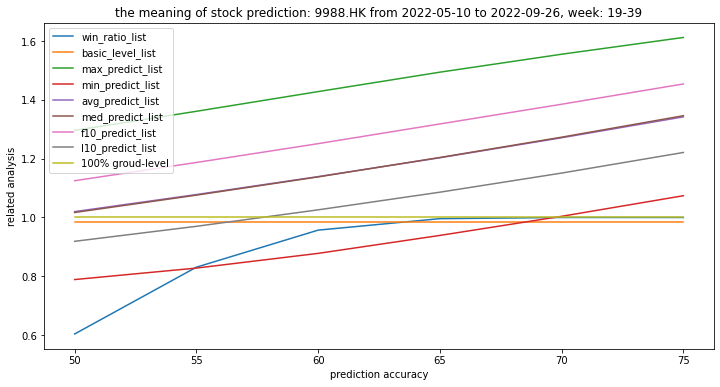

In [87]:
for start_week in range(1, 20):
  #start_week, end_week = 21, 41
  end_week = start_week + 20
  week_period = end_week - start_week
  start_date = df_data[df_data["weekNumber"]==start_week].iloc[0]["ymd_time"]
  start_date = str(start_date)[:10]
  end_date = df_data[df_data["weekNumber"]==end_week].iloc[0]["ymd_time"]
  end_date = str(end_date)[:10]
  title_name = "from " + start_date + " to " + end_date + ", week: " + str(start_week) + "-" + str(end_week)

  # for visualization
  predict_accuracy_list = []
  win_ratio_list = []
  basic_level_list = []
  max_predict_list = []
  min_predict_list = []
  avg_predict_list = []
  med_predict_list = []
  f10_predict_list = []
  l10_predict_list = []

  # 
  week_num_return = get_weekly_return(df_data, start_week, end_week)
  week_num_return

  #
  transact_fee=-0.25*0.01
  # buy_and_hold0 = 1.0 * (1+transact_fee) * (df_data.iloc[-1]['Close'] / df_data.iloc[0]['Close']) * (1+transact_fee)
  # buy_and_hold0, 
  buy_and_hold1 = basic_level_strategy(week_num_return, transact_fee)
  buy_and_hold1

  # 
  accuracy_ratio = 0.5
  for ii in range(6):
    print( "prediction accuracy", round(accuracy_ratio*100, 2), "%" )
    v1, v2, all_permutations = permutation_Cn(week_period, int(week_period*accuracy_ratio))
    simulations = get_possible_permutations(week_period, accuracy_ratio, all_permutations*3)
    print(all_permutations, len(simulations), round(len(simulations)/all_permutations*100, 2), "%")

    return_record = []
    for sim in simulations[:]:
      week_predictions = forge_week_predictions(sim, week_num_return)
      #print(week_predictions)
      algo_return = algo_trading_strategy(week_predictions, week_num_return, transact_fee)
      return_record.append(algo_return)

    #
    offset = 0.01
    counter = 0
    for rtn in sorted(return_record):
      if rtn > buy_and_hold1+offset:
        counter += 1
    win_ratio = round( counter/len(return_record), 3 )
    print( counter, len(return_record), win_ratio, "% win" )
    mx, mn, avg, med, first_10, last_10 = statistical_indicators(return_record)
    print( round(buy_and_hold1, 3), " vs ", mn, last_10, avg, med, first_10, mx )
    #
    predict_accuracy_list.append( round(accuracy_ratio*100) )
    win_ratio_list.append( win_ratio )
    basic_level_list.append( round(buy_and_hold1, 3) )
    max_predict_list.append( mx )
    min_predict_list.append( mn )
    avg_predict_list.append( avg )
    med_predict_list.append( med )
    f10_predict_list.append( first_10 )
    l10_predict_list.append( last_10 )
    #
    accuracy_ratio += 0.05

  x = predict_accuracy_list
  ys = [
    win_ratio_list, basic_level_list,
    max_predict_list, min_predict_list, avg_predict_list,
    med_predict_list, f10_predict_list, l10_predict_list
  ]
  draw_lines(x, ys, tn, title_name)